In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

6.8.2.1 Simulate 10,000 samples of ARMA(2,2)

In [2]:
np.random.seed(42)

ar2 = np.array([1, -0.33, -0.50])  # Coefficient with opposite sign than in equation
ma2 = np.array([1, 0.9, 0.3])    # Coefficient with same sign than in equation

ARMA_2_2 = ArmaProcess(ar2, ma2).generate_sample(nsample=10000)

6.8.2.2 Plot simulated process

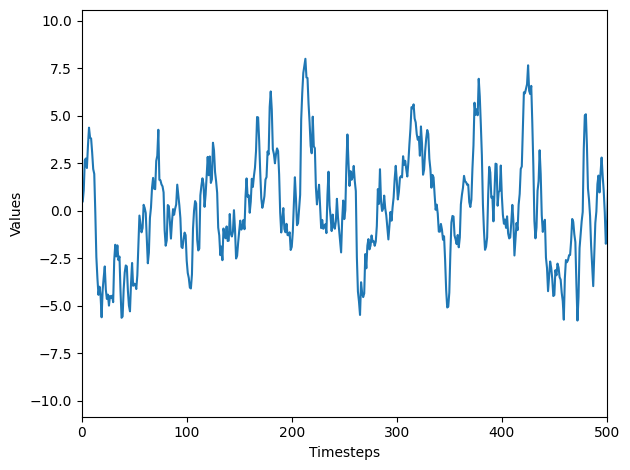

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(ARMA_2_2)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Values')

plt.xlim(0, 500)

plt.tight_layout()

6.8.2.3 Test for stationarity

In [4]:
ADF_result = adfuller(ARMA_2_2)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -20.684894435243283
p-value: 0.0


Not required: ACF and PACF

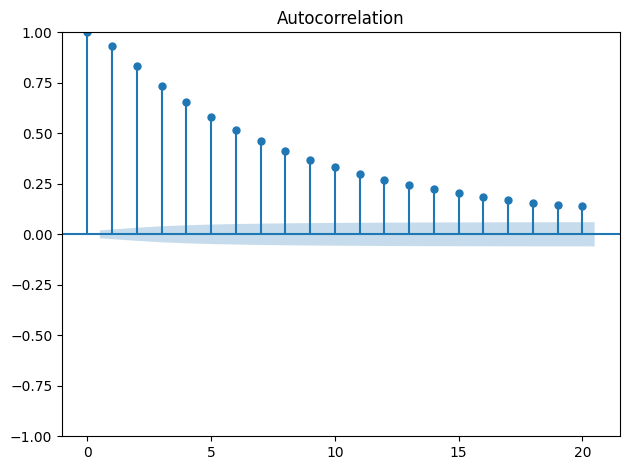

In [5]:
plot_acf(ARMA_2_2, lags=20)

plt.tight_layout()

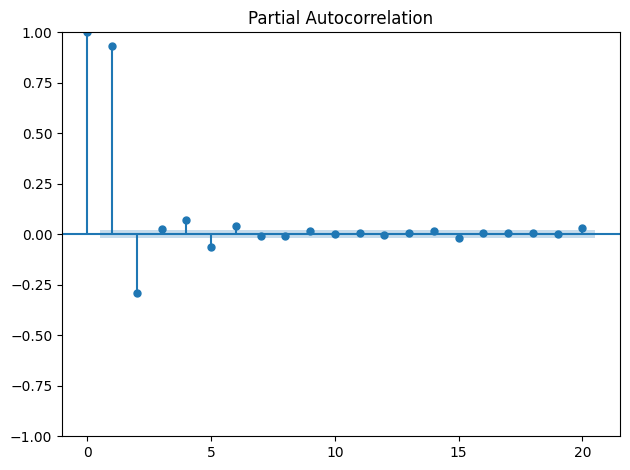

In [6]:
plot_pacf(ARMA_2_2, lags=20)

plt.tight_layout()

6.8.2.4 200 timesteps test, the rest all train

In [7]:
df_diff = pd.DataFrame({'values': ARMA_2_2})

train = df_diff[:-200]
test = df_diff[-200:]

print(len(train))
print(len(test))

9800
200


6.8.2.5 Range of values p,q and unique combinations

In [8]:
ps = range(0, 5, 1)
qs = range(0, 5, 1)

order_list = list(product(ps, qs))
print(order_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]


6.8.2.6 Fit all unique ARMA models, select the one with the lowest AIC

In [9]:
from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [10]:
result_df = optimize_ARMA(train['values'], order_list)
result_df

  0%|          | 0/25 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 2)",27905.101691
1,"(2, 3)",27905.310112
2,"(2, 2)",27905.573367
3,"(4, 2)",27906.577344
4,"(2, 4)",27906.997659
5,"(3, 3)",27907.356959
6,"(1, 4)",27907.599073
7,"(3, 4)",27908.109598
8,"(4, 3)",27908.451819
9,"(4, 4)",27909.768246


ARMA(2,2) is nto the model with the lowest AIC

6.8.2.7 Select best model and store residuals

Because ARMA(3,2), ARMA(2,3) and ARMA (2,2) have all very similar AIC score, we pick the simplest, ARMA(2,2)

In [11]:
model = SARIMAX(train['values'], order=(2,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)


6.8.2.8 Qualitative analysis of residuals with plot_diagnostics

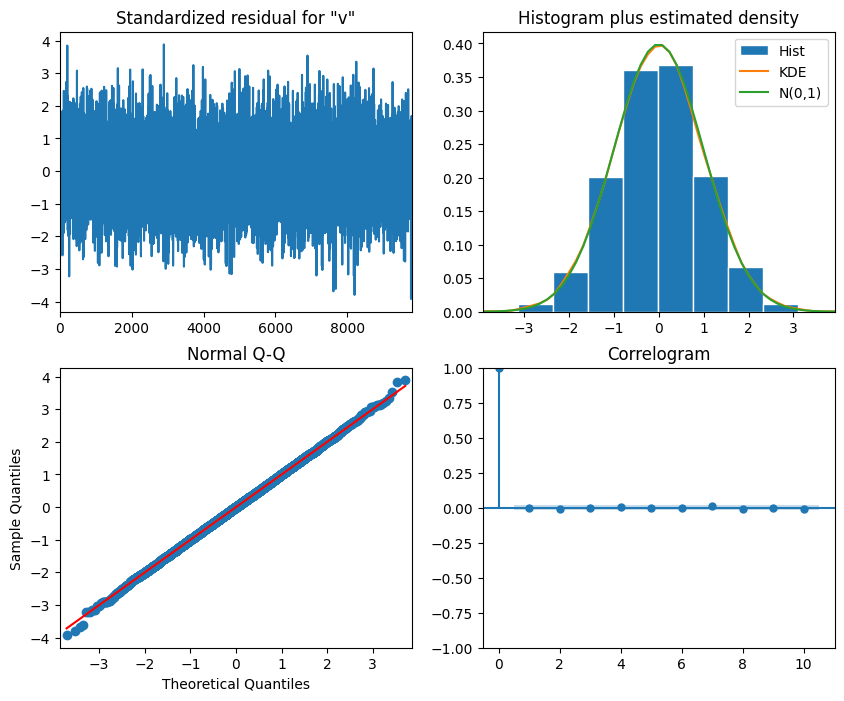

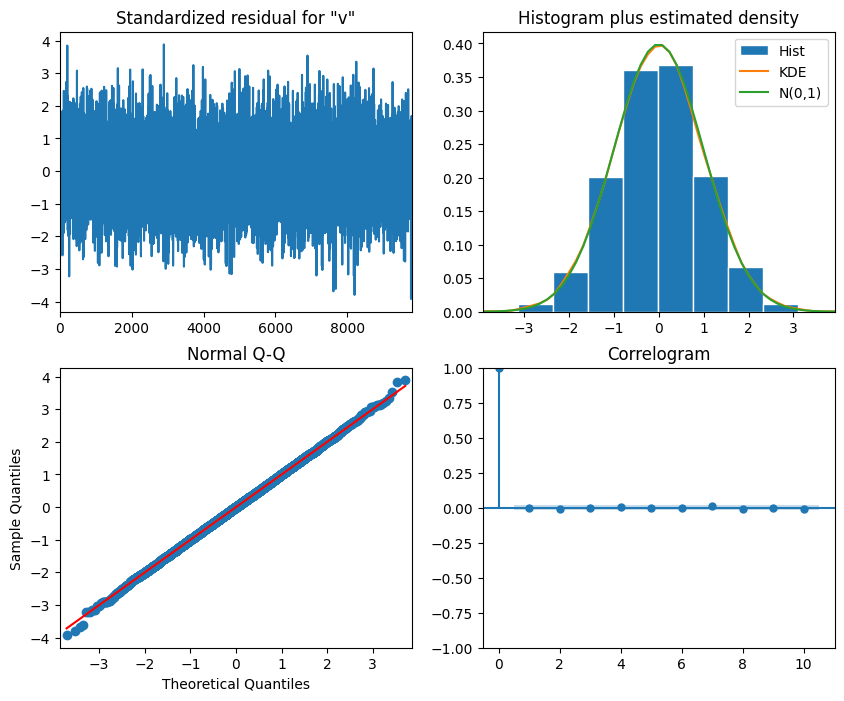

In [12]:
model_fit.plot_diagnostics(figsize=(10, 8))

Q-Q plot shows a straight line

Correlogram does not show significant coefficients

6.8.2.9 Quantitative analysis of residuals with Ljung-Box Test

In [13]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model_fit.resid

lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_dataframe

,lb_stat,lb_pvalue
1,0.042296,0.837056
2,0.414491,0.812820
3,0.514013,0.915802
4,0.819529,0.935811
5,0.819685,0.975761
6,1.075739,0.982577
7,2.077897,0.955403
8,3.083728,0.928994
9,3.102822,0.960078
10,3.415384,0.969894


All p-values are above 0.05

Residuals are not correlated

6.8.2.10 Rolling Forecast method, predict the test set

In [14]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

In [15]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

,values,pred_mean,pred_last_value,pred_ARMA
9800,-0.275170,-0.025645,-0.837188,-1.182182
9801,0.479336,-0.025645,-0.837188,-1.137223
9802,3.059285,-0.025619,0.479336,0.736508
9803,2.459694,-0.025619,0.479336,0.627930
9804,2.941582,-0.025051,2.459694,2.100925


6.8.2.11 Plot forecasts

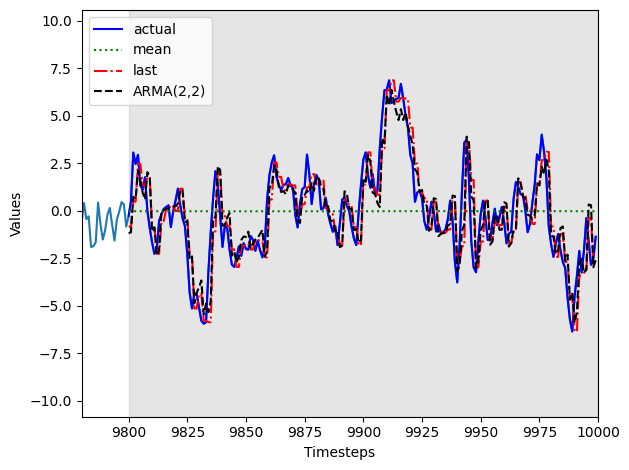

In [16]:
fig, ax = plt.subplots()

ax.plot(df_diff['values'])
ax.plot(test['values'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Values')

ax.axvspan(9800, 10000, color='#808080', alpha=0.2)

ax.set_xlim(9780, 10000)

plt.tight_layout()

6.8.2.12 Evaluate using MSE

In [17]:
mse_mean = mean_squared_error(test['values'], test['pred_mean'])
mse_last = mean_squared_error(test['values'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['values'], test['pred_ARMA'])

print(mse_mean, mse_last, mse_ARMA)

6.263912001945173 2.1552606973982593 1.7598494206090083


ARMA(2,2) performed best